# Описание проекта: промышленность
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

#Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

<b>data_arc_new.csv</b>— данные об электродах;<br> 
<b>data_bulk_new.csv</b> — данные о подаче сыпучих материалов (объём);<br>
**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);<br>
**data_gas_new.csv** — данные о продувке сплава газом;<br>
**data_temp_new.csv** — результаты измерения температуры;<br>
**data_wire_new.csv** — данные о проволочных материалах (объём);<br>
**data_wire_time_new.csv** — данные о проволочных материалах (время).<br>


**key** — номер партии;<br>
**Начало нагрева дугой (start_arc_heating)** — время начала нагрева;<br>
**Конец нагрева дугой (end_arc_heating)** — время окончания нагрева;<br>
**Активная мощность (active_power)** — значение активной мощности;<br>
**Реактивная мощность (reactive_power)** — значение реактивной мощности.<br>
**key** — номер партии;<br>
**Bulk 1 … Bulk 15** — объём подаваемого материала.<br>
**key** — номер партии;<br>
**Bulk 1 … Bulk 15** — время подачи материала.<br>
**key** — номер партии;<br>
**Газ 1 (gas_1)** — объём подаваемого газа.<br>
**key** — номер партии;<br>
**Время замера (measurement_time)** — время замера;<br>
**Температура (temperature)** — значение температуры.<br>
**key** — номер партии;<br>
**Wire 1 … Wire 15** — объём подаваемых проволочных материалов.<br>
**key** — номер партии;<br>
**Wire 1 … Wire 15** — время подачи проволочных материалов.<br>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

RST = 190224

In [3]:
path_11 = '/datasets/data_arc_new.csv'
path_12 = '/datasets/data_bulk_new.csv'
path_13 = '/datasets/data_bulk_time_new.csv'
path_14 = '/datasets/data_gas_new.csv'
path_15 = '/datasets/data_temp_new.csv'
path_16 = '/datasets/data_wire_new.csv'
path_17 = '/datasets/data_wire_time_new.csv'




path_21 = "C:\\DS\\YP\\S23\\data_arc_new.csv"
path_22 = "C:\\DS\\YP\\S23\\data_bulk_new.csv"
path_23 = "C:\\DS\\YP\\S23\\data_bulk_time_new.csv"
path_24 = "C:\\DS\\YP\\S23\\data_gas_new.csv"
path_25 = "C:\\DS\\YP\\S23\\data_temp_new.csv"
path_26 = "C:\\DS\\YP\\S23\\data_wire_new.csv"
path_27 = "C:\\DS\\YP\\S23\\data_wire_time_new.csv"



def generate_data (path_1, path_2):
    if os.path.exists(path_1):
        df = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2)
    else:
        print('Something is wrong')
    return df


In [4]:
data_arc_new = generate_data(path_11, path_21)
data_bulk_new = generate_data(path_12, path_22)
data_bulk_time_new = generate_data(path_13, path_23)
data_gas_new = generate_data(path_14, path_24)
data_temp_new = generate_data(path_15, path_25)
data_wire_new = generate_data(path_16, path_26)
data_wire_time_new = generate_data(path_17, path_27)

## Предобработка данных

### Данные об электродах

In [5]:
# выведем на экран каждый датасет
def df_print(df):
    print("Распечатаем первые строчки датасета")
    display(df.head(5));
    print("Выведем статистику по данным")
    display(df.describe());
    print("Информация по датасету")
    display(df.info());

In [6]:
df_print(data_arc_new)

Распечатаем первые строчки датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Выведем статистику по данным


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Переименуем название колонок на более удобные

In [7]:
# переименовываем столбцы
data_arc_new.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

#проверка
data_arc_new.columns

Index(['key', 'start_arc_heating', 'end_arc_heating', 'active_power',
       'reactive_power'],
      dtype='object')

Проверим значения на пропуски

In [8]:
data_arc_new.isna().sum()

key                  0
start_arc_heating    0
end_arc_heating      0
active_power         0
reactive_power       0
dtype: int64

Пропусков нет. Проверим данные на выбросы и неадекватные значения. Построим boxplot и гистрограмму

In [9]:
# функция для отрисовки гистограмм
def draw_histogram (df, column, title, bins=15,
                   figsize=(14,5), color='red',
                   xlabel='', ylabel='', rotation=0,
                   xlim=None, ylim=None):
    plt.figure(figsize=figsize)
    
    ax = sns.displot(
        df[column],
        color=color,
        kde=False,
        bins=bins
    )
    
    if (xlim != None):
        plt.xlim(xlim)
    if (ylim != None):
        plt.ylim(ylim)
        
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=title
    )    
    
    if rotation != 0:
        plt.xticks(rotation=rotation)

In [10]:
#  функция для отрисовкия ящика с усами
def draw_boxplot (df, column, title,
                 figsize=(14,5), color='red',
                 xlabel='', xlim=None,):
    plt.figure(figsize=figsize)
    
    ax = sns.boxplot(
        x=df[column],
        color=color
    )
    
    if(xlim != None):
        xlim=xlim
        
    ax.set(xlabel=xlabel,
          title=title
          )

<Figure size 1008x360 with 0 Axes>

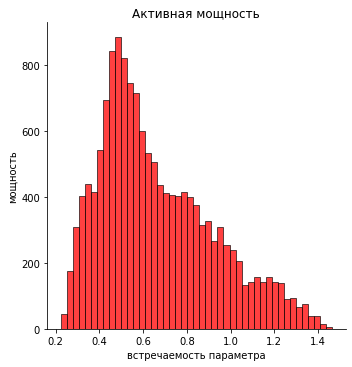

In [11]:
#  построим гистрограммы
draw_histogram(data_arc_new, column='active_power', title='Активная мощность',bins=45,
               xlabel='встречаемость параметра', ylabel='мощность')

In [12]:
data_arc_new

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


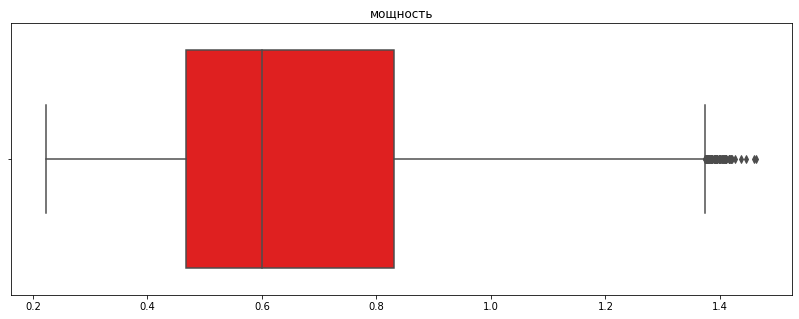

In [13]:
draw_boxplot(data_arc_new, column='active_power', title='мощность')

Распределение не вызывает подозрение. Выбросы на графике boxplot не сильно далеко остоят от верхего квантиля. Удалять или изменять ну будем

<Figure size 1008x360 with 0 Axes>

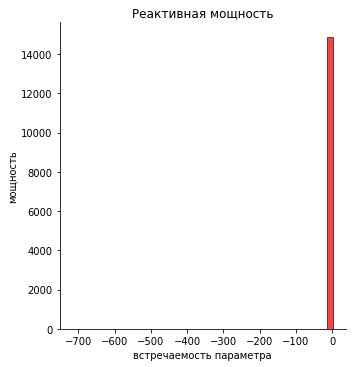

In [14]:
draw_histogram(data_arc_new, column='reactive_power', title='Реактивная мощность',bins=45,
               xlabel='встречаемость параметра', ylabel='мощность')

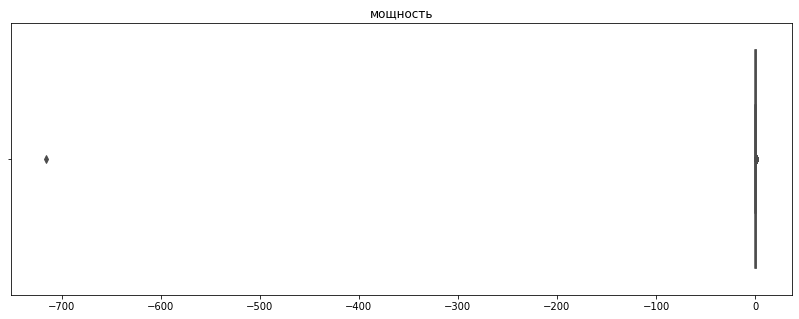

In [15]:
draw_boxplot(data_arc_new, column='reactive_power', title='мощность')

Явно есть неадекватной значение ниже -700. Заменим выброс на медианное значение.

<Figure size 1008x360 with 0 Axes>

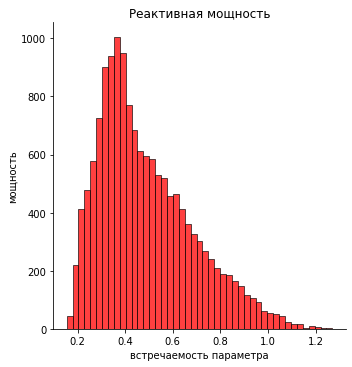

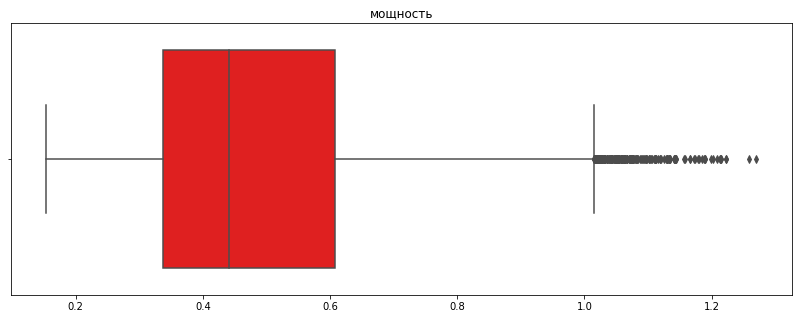

In [16]:
#заменяем выброс на медианное значение
data_arc_new['reactive_power'] = data_arc_new['reactive_power'].replace(-715.479924, data_arc_new['reactive_power'].median())

# проверка 
draw_histogram(data_arc_new, column='reactive_power', title='Реактивная мощность',bins=45,
               xlabel='встречаемость параметра', ylabel='мощность')
draw_boxplot(data_arc_new, column='reactive_power', title='мощность')

Значения стали более адеватными. Далее приведём в рабоий вид столбцы со временем. В том виде как есть сейчас данные о времени бесползны. Изменим тип данных колонок и писчитаем длительность операций.

In [17]:
# изменяем тип данных
data_arc_new['start_arc_heating'] = pd.to_datetime(data_arc_new['start_arc_heating'], errors='coerce')
data_arc_new['end_arc_heating'] = pd.to_datetime(data_arc_new['end_arc_heating'], errors='coerce')
# проверка
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [18]:
# введём новую колонку, которач будет содержать разность между окончанием стартом и подачи мощности
data_arc_new['time'] = (data_arc_new.end_arc_heating - data_arc_new.start_arc_heating).dt.total_seconds()
# проверка
data_arc_new['time'].head()


0    228.0
1    185.0
2    172.0
3    365.0
4    148.0
Name: time, dtype: float64

Также посмотрим распредление нового столбца и проверим на выбросы

<Figure size 1008x360 with 0 Axes>

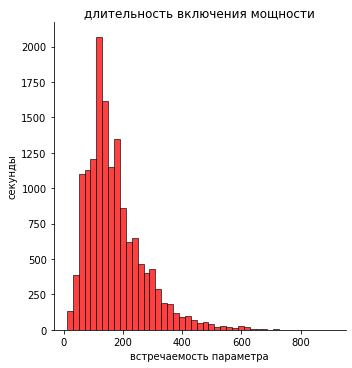

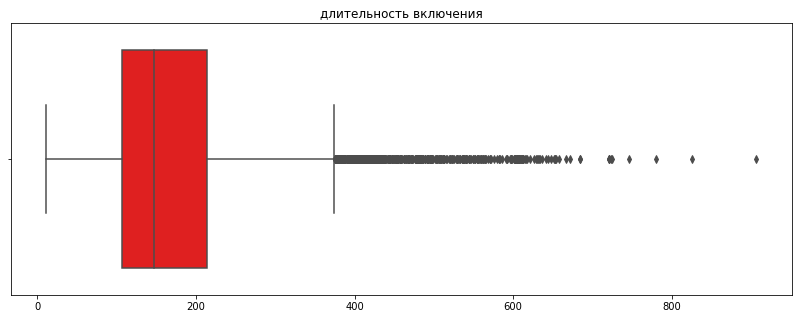

In [19]:
draw_histogram(data_arc_new, column='time', title='длительность включения мощности',bins=45,
               xlabel='встречаемость параметра', ylabel='секунды')
draw_boxplot(data_arc_new, column='time', title='длительность включения')

Есть значения оторые отличаются сильнее. Неизветно насколько эти значения адекватны, оставим как есть.

В дальнейшем нужно будем объединить таблицы по ключу. Приведём таблцу к размерам других таблиц. около 3000 значений. 

Возмьём средине значения по колонка по времени и мощностям. 

In [20]:
# Проврим количество уникальных значений ключей.
len(np.unique (data_arc_new['key']))

3214

In [21]:
# сгруппируем значения по ключу. По каждому столбцу возьём среднее значение.
data_arc_new = pd.pivot_table(data_arc_new, values=['time', 'active_power', 'reactive_power'],
                              index='key', aggfunc='mean').reset_index()
# проверка
data_arc_new.head()

,key,active_power,reactive_power,time
0,1,0.607346,0.428564,219.60
1,2,0.534852,0.363339,202.75
2,3,0.812728,0.587491,131.00
3,4,0.676622,0.514248,185.25
4,5,0.563238,0.421998,217.25


**Вывод:**

Загрузили датасеты. Проверили датасет "данные об электродах" на пропуски и выбросы. Пропуски не обнаружены, выброс был заменён на медианное значение. Заменили тип данных столбца столбцов с временим начала и окончания подачаи мощности. Сами данные о времени бесползны для обучения модели. Поэтому эти столбцы удалили, вместо них ввели новый столбец - длительность подачи мощности.

### Данные о сыпучих матреиалах(объем)

In [22]:
df_print(data_bulk_new)

Распечатаем первые строчки датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Выведем статистику по данным


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Для удобства заменим названия стобцов

In [23]:
# замена названий столбцов
data_bulk_new.columns=[ 'key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                       'bulk_6',  'bulk_7', 'bulk_8',  'bulk_9',  'bulk_10',
                       'bulk_11',  'bulk_12',  'bulk_13',  'bulk_14',  'bulk_15']

Заметно большое количество пропущенных значений. В данном датасете. Пропущенные данные означают отсутсвие ввода материалов в расплав. Заменим пропуски на 0

In [24]:
# заполнение пропусков
data_bulk_new = data_bulk_new.fillna(0)

# проверка
display(data_bulk_new.head())
print('наличие пропусков')
display(data_bulk_new.isna().sum())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


наличие пропусков


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

**Вывод**

Заменили пропущенные значения на значение 0, т.к. в данном случае пропущенные значения означают отсутсвие ввода.

### Данные о сыпучих матреиалах(время)

In [25]:
df_print(data_bulk_time_new)

Распечатаем первые строчки датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Выведем статистику по данным


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Для удобства заменим названия стобцов

In [26]:
data_bulk_time_new.columns=[ 'key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                       'bulk_6',  'bulk_7', 'bulk_8',  'bulk_9',  'bulk_10',
                       'bulk_11',  'bulk_12',  'bulk_13',  'bulk_14',  'bulk_15']

В данном датасете пропущенные значение также как и в случаем объему означают отсутвие ввода материала.

Указан только один временной параметр. Нет диапазона.
Пока не ясно как мы можем использовать эти данные для обучения модели.

**Вывод:**

Датасет содержащий время ввода сыпучих матераилов будет бесполезен для обучения модели. Его нет смысла изменять и в дальнейшем объединять в общую выборку.


### Данные о продувке сплава газом

In [27]:
df_print(data_gas_new)

Распечатаем первые строчки датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Выведем статистику по данным


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Переименуем колонку

In [28]:
data_gas_new.columns = ['key', 'gas_1']

Проверим данные на пропуски

In [29]:
data_gas_new.isna().sum()

key      0
gas_1    0
dtype: int64

Проверим данные на аномальные значения

<Figure size 1008x360 with 0 Axes>

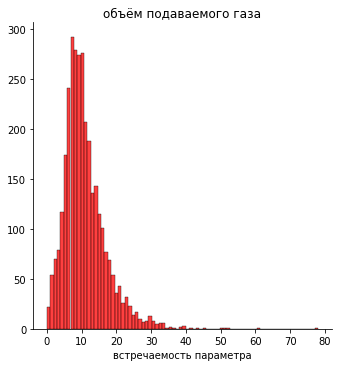

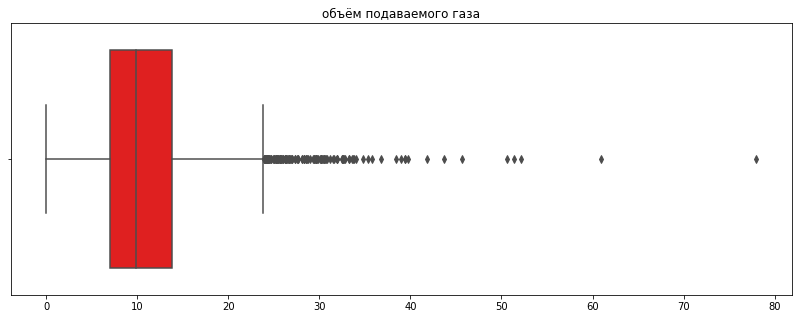

In [30]:
draw_histogram(data_gas_new, column='gas_1', title='объём подаваемого газа',bins=80,
               xlabel='встречаемость параметра', ylabel='')
draw_boxplot(data_gas_new, column='gas_1', title='объём подаваемого газа')

Сложно сказать являются ли выбросы аномалией. Редкие значения могут негативно повлиять на обучение модели.

# Результаты измерения температуры

In [31]:
df_print(data_temp_new)

Распечатаем первые строчки датасета


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Выведем статистику по данным


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Изменим название колонки

In [32]:
data_temp_new.columns = ['key', 'msmnt_time', 'temperature']

В результатах измерения температуры нас интересуте температура в начале замеров и в конце. Сгруппируем таблицу по мин и максимальным значениям температру по каждому замеру.

In [33]:
# сначала изменим тип данных столбца времени
data_temp_new['msmnt_time'] =  pd.to_datetime(data_temp_new['msmnt_time'], errors='coerce')

# проверка
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   msmnt_time   18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [34]:
# группировка данных по ключу получаем входящую и выходящую температуру
data_temp_new = data_temp_new.groupby(by = 'key', as_index = False).agg(['first', 'last'])
# проверка
data_temp_new.head()

msmnt_time                     temperature        
                  first                last       first    last
key                                                            
1   2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0  1613.0
2   2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0  1602.0
3   2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0  1599.0
4   2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0  1625.0
5   2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0  1602.0

Время нам больше не нужно, удалим столбцы. Проверим равенство входящих и выхожящих температрур. Для этого введём временную переменную r, которая будет являтся разностью между температурами.

In [35]:
# удалим столбцы со временем
data_temp_new = data_temp_new.drop('msmnt_time', axis=1)
# проверка
data_temp_new.head()

temperature        
          first    last
key                    
1        1571.0  1613.0
2        1581.0  1602.0
3        1596.0  1599.0
4        1601.0  1625.0
5        1576.0  1602.0

In [36]:
# переименуем столбцы для удобства
data_temp_new = data_temp_new.reset_index()
data_temp_new.columns = ['key', 'first_temperature', 'last_temperature']

In [37]:
# вычитаем температуры
data_temp_new['t'] = data_temp_new.first_temperature - data_temp_new.last_temperature

In [38]:
# проверём наличие одинаковых температур
data_temp_new['t'][data_temp_new['t'] == 0].count()

783

In [39]:
# оставляем только нужные значения
data_temp_new = data_temp_new[data_temp_new.t != 0]
# проверка
data_temp_new['t'][data_temp_new['t'] == 0].count()

0

In [40]:
# удаляем временный столбец
data_temp_new = data_temp_new.drop('t', axis=1)
data_temp_new.head()

,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Проверим данных на аномальные значения и выбросы

<Figure size 1008x360 with 0 Axes>

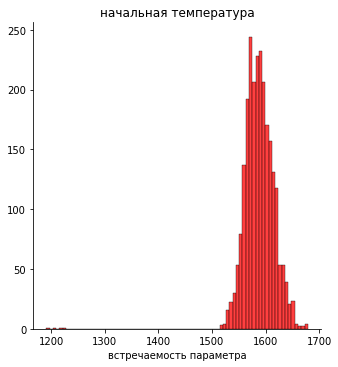

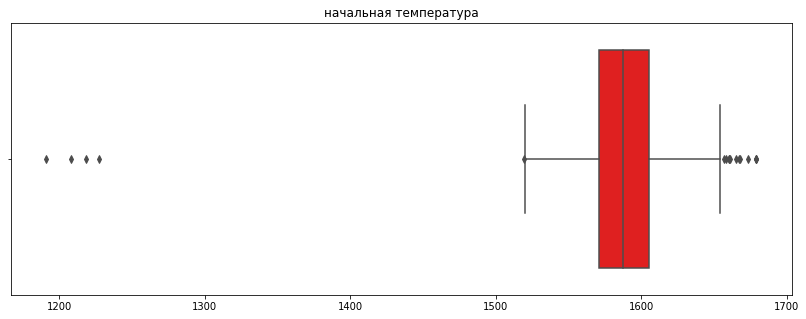

In [41]:
draw_histogram(data_temp_new, column='first_temperature', title='начальная температура',bins=80,
               xlabel='встречаемость параметра', ylabel='')
draw_boxplot(data_temp_new, column='first_temperature', title='начальная температура')

Температура плавления стали около 1500°C в зависимости от состава может быть меньши или больше. 
Но точно не меньше 1300°C, это явные аномалии. Эти аномалии удалим в тренировочной выборке, если они туда войдут

Далее также проверим конечные температуры

<Figure size 1008x360 with 0 Axes>

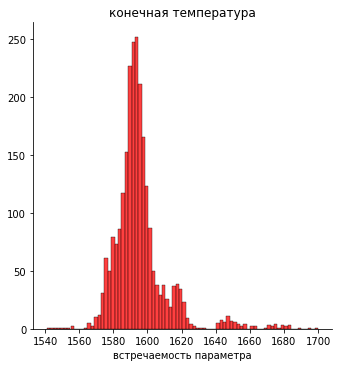

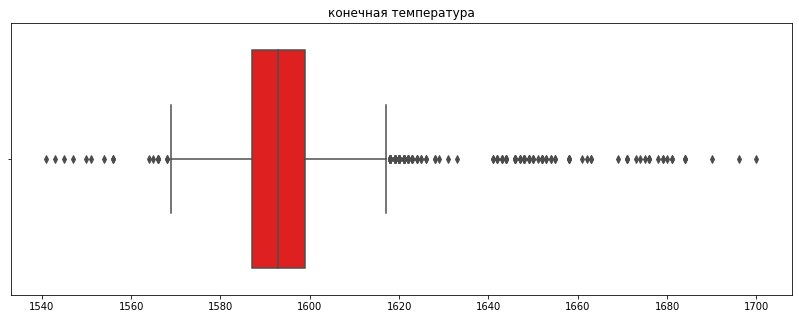

In [42]:
draw_histogram(data_temp_new, column='last_temperature', title='конечная температура',bins=80,
               xlabel='встречаемость параметра', ylabel='')
draw_boxplot(data_temp_new, column='last_temperature', title='конечная температура')

Есть выбросы, но нет явных аномалий. Оставим значения как есть

**Вывод:**

Подготовили данные. Обнаружены аномалии в столце 'начальная температура', в виде температуры ниже температуры плавления стали. Это может быть ошибкой измерений, либо слишком ранним началом записи температур, то расплавления состава.
Есть температуры, которые похожи на выбросы, оставим их т.к. такие температуры тоже выжны и нужно обучать модели с учётом этх температур.

### Данные о проволочных материалах (объём)

In [43]:
df_print(data_wire_new)

Распечатаем первые строчки датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выведем статистику по данным


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Переименуем столбцы

In [44]:
data_wire_new.columns=(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'])

В данных о проволочных материалах также как и в данных о сыпучих материалах пропуски означают отсутсвие ввода.

Заменим пропуски на 0

In [45]:
# замена пропусков
data_wire_new = data_wire_new.fillna(0)
# проверка
data_wire_new.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

**Вывод:**

В данном датасете как и в случае с датасетом сыпучих материалов пропуски означают отсутсвие ввода материалов. Поэтому пропуски заменили на 0.

### Данные о проволочных материалах (время)

In [46]:
df_print(data_wire_time_new)

Распечатаем первые строчки датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выведем статистику по данным


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

**Вывод**

Данные о времени ввода проволных материалов представляются бесполезными для обучения модели.

### Объединение и анализ данных

Объединим таблицы в одну.

In [47]:
# объединение таблиц
df = data_temp_new.merge(data_arc_new, how = 'inner', on = 'key')
df = df.merge(data_bulk_new)
df = df.merge(data_gas_new)
df = df.merge(data_wire_new)

In [48]:
# проверка
df.head()

,key,first_temperature,last_temperature,active_power,reactive_power,time,bulk_1,bulk_2,bulk_3,bulk_4,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,0.607346,0.428564,219.60,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,0.534852,0.363339,202.75,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,0.812728,0.587491,131.00,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,0.676622,0.514248,185.25,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,0.563238,0.421998,217.25,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построим график корреляции

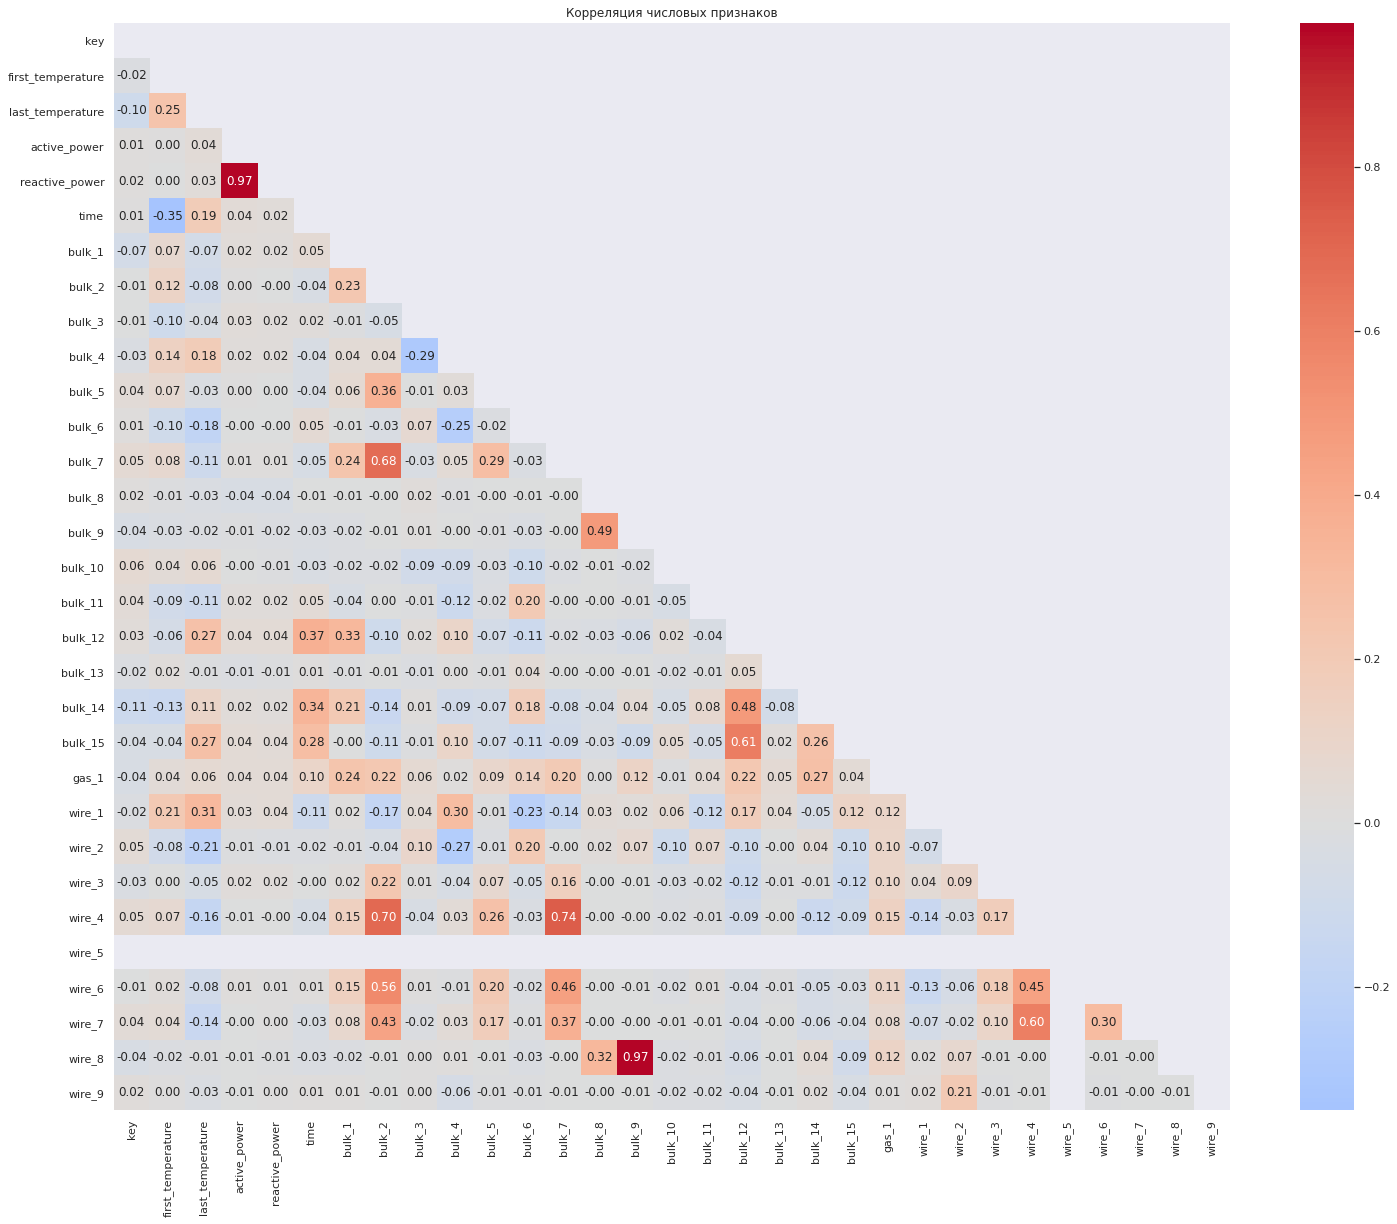

In [49]:
sns.set(rc={"figure.figsize":(25, 20)})
heat_corr = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, fmt='.2f',
            center= 0, cmap='coolwarm', mask=heat_corr);
plt.title('Корреляция числовых признаков')
plt.show();

Видно что мощность максимально коррелируем между собой, сюда также входит коореляция между материалами bulk_9 wire_8. Удалим параметр мощности максимально коррелирующие материалы и пустой wire_5. Значение key, также не понадобится для обучения

In [50]:
# удаление гиперкореллирующих столбцов
df = df.drop(['key', 'active_power', 'bulk_9', 'wire_5'], axis=1)

Повторно построим график корреляции

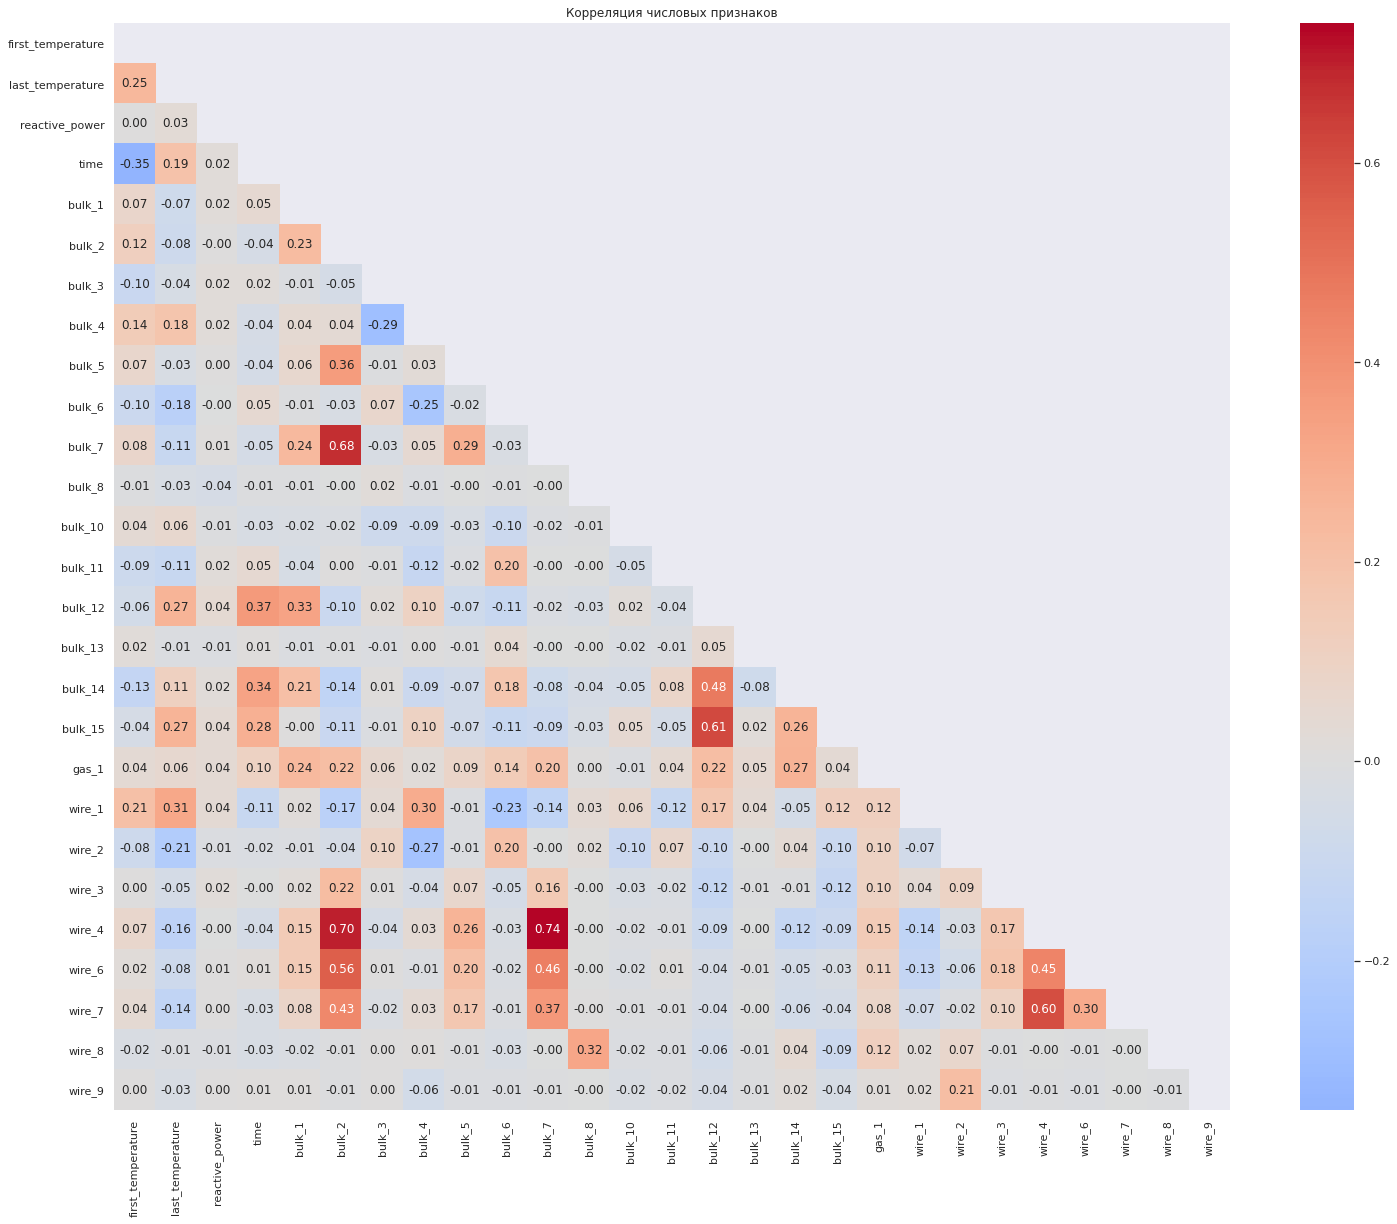

In [51]:
sns.set(rc={"figure.figsize":(25, 20)})
heat_corr = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, fmt='.2f',
            center= 0, cmap='coolwarm', mask=heat_corr);
plt.title('Корреляция числовых признаков')
plt.show();

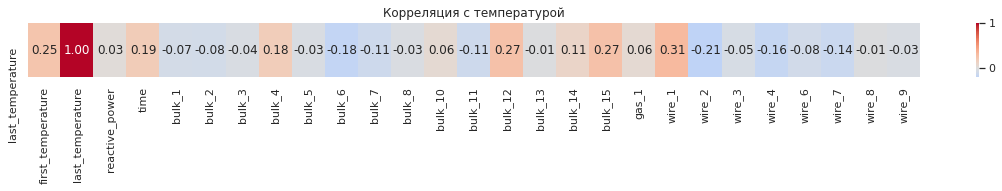

In [52]:
sns.set(rc={"figure.figsize":(20, 1)})
matrix = df.corr()
sns.heatmap(matrix.sort_values(by='last_temperature', ascending=False).head(1), annot = True,
            center= 0, cmap='coolwarm', fmt = '.2f');
plt.title('Корреляция с температурой')
plt.show();


# num=df.select_dtypes(exclude='object')
# numcorr=num.corr()
# f,ax=plt.subplots(figsize=(17,1))
# sns.heatmap(numcorr.sort_values(by=['last_temperature'], ascending=False).head(1), cmap='Blues')
# plt.title("Корреляция числовых признаков с температурой", weight='bold', fontsize=18)
# plt.show()

Выглядит адекватно.

Разделим датасет на тренировочную и тестовую выборку в пропоркции 3:1

In [53]:
# разделяем датасет на тренировочную и тестовую выборки
X, y = train_test_split(df, test_size = 0.25, random_state = RST)

В части обработки датасетов были обнаружены аномальные значения в столбце first_temperature если, те что ниже 1300°C. Удалим эти значения, если они вошли в тренировочную выборку.

In [54]:
df = df.query('first_temperature > 1300')

Отмасштабируем признаки

In [55]:
# масштабирование признаков
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ("last_temperature")]
scaler = StandardScaler()
scaler.fit(X[numeric])
X[numeric] = scaler.transform(X[numeric])
y[numeric] = scaler.transform(y[numeric])

Разделение признков

In [56]:
# Разделение признаков на обучающие и целевые
X_train = X.drop(['last_temperature'], axis = 1)
y_train = X['last_temperature']
X_test = y.drop(['last_temperature'], axis = 1)
y_test = y['last_temperature']

**Вывод**

Загрузили данные. Проверили на пропуски и аномалии. Заменили пропуски. Объединили датасеты в один, кроме датасета времени ввода сыпучих материалов и датасета времени ввода проволочных материалов. Удалили столбцы с гиперкорреляцией. И разбили датасет на обучающую и тестовую выборки.

## Обучение моделей

### LinearRegression

In [57]:
%%time

model_LR = LinearRegression() # создание модели

cv_search_mae = (cross_val_score(model_LR,
                                 X_train,
                                 y_train,
                                 scoring='neg_mean_absolute_error',
                                 cv=5).mean()*-1)

cv_search_mse = (cross_val_score(model_LR,
                                 X_train,
                                 y_train,
                                 scoring='neg_mean_squared_error',
                                 cv=5).mean()*-1)    

cv_search_mape  = (cross_val_score(model_LR,
                                 X_train,
                                 y_train,
                                 scoring='neg_mean_absolute_percentage_error',
                                 cv=5).mean()*-1)  


# находим среднее отклонение
#print("MAE: ", mean_absolute_error(y_valid, predictions))
print('MAE при кросс-валидации для линейной регресии: {:.2f}'.format(cv_search_mae))
print('MSE при кросс-валидации для линейной регресии: {:.2f}'.format(cv_search_mse))
print('MAPE для линейной регресии: {:.2f}'.format(cv_search_mape))

MAE при кросс-валидации для линейной регресии: 7.18
MSE при кросс-валидации для линейной регресии: 98.50
MAPE для линейной регресии: 0.00
CPU times: user 798 ms, sys: 873 ms, total: 1.67 s
Wall time: 1.62 s


Далее обучим модель RandomForestRegressor. Для RandomForestRegressor подберём оптимальные гиперпараметры с помощью GridSearchCV

In [58]:
# варианты параметров для поиска оптимальных для модели случайный лес
param_grid_RFR = { 
    'n_estimators': [30, 90, 150, 210],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 7, 12]
}


In [59]:
%%time 
model_RFR =  RandomForestRegressor(random_state=RST) # создание модели

# используем GridSearchCV для оптимизации гиперпараметров и кросс-валидации
gs = GridSearchCV(model_RFR,
                    param_grid = param_grid_RFR,
                    cv=5,
                    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']  ,
                    n_jobs=1, 
                    refit='neg_mean_absolute_error',
                    return_train_score=True
                    )

# обучение GridSearchCV
gs.fit(X_train, y_train)
cv_result = gs.cv_results_
print('MAE равно {:.2f}'.format(gs.best_score_*-1))
print()
print('Лучише  параметры модели:', gs.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_para

MAE равно 6.93

Лучише  параметры модели: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 210}
CPU times: user 43.2 s, sys: 309 ms, total: 43.5 s
Wall time: 43.6 s


In [60]:
# Выведем значения лучшее значение MAE и для лучшего MAE метрики RMSE, и MAPE
display(pd.DataFrame(cv_result)[['params',
                                'mean_test_neg_mean_absolute_error',
                                'mean_test_neg_root_mean_squared_error',
                                'mean_test_neg_mean_absolute_percentage_error',
                                'rank_test_neg_mean_absolute_error']].\
                                 sort_values('rank_test_neg_mean_absolute_error').head(1)            
       )

,params,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_error
31,"{'max_depth': 12, 'max_features': 'sqrt', 'n_e...",-6.927265,-9.418697,-0.004341,1


В итоге MAE равно 6,81, RMSE равно 89,98 и MAPE равно 0,42%

Далее обучим модель CatBoost. Для Catboost подберём оптимальные гиперпараметры с помощью фреймворка GridSearchCV

In [61]:
# Определение гиперпараметров для оптимизации 
param_grid_CB = { 
    'iterations': [100, 150, 200, 250],
    'depth' : [3, 6, 9, 12]
}

In [62]:
%%time

model_CB = CatBoostRegressor(random_state=RST) # создание модели

# используем GridSearchCV для оптимизации гиперпараметров и кросс-валидации
gs = GridSearchCV(model_CB,
                    param_grid = param_grid_CB,
                    cv=5,
                    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                    n_jobs=1, 
                    refit='neg_mean_absolute_error',
                    return_train_score=True
                    )

# обучение GridSearchCV
gs.fit(X_train, y_train)
cv_result = gs.cv_results_
print('MAE равно {:.2f}'.format(gs.best_score_*-1))
print()
print('Лучише  параметры модели:', gs.best_params_)

Learning rate set to 0.279918
0:	learn: 10.9197420	total: 47.1ms	remaining: 4.66s
1:	learn: 10.6177026	total: 48.3ms	remaining: 2.37s
2:	learn: 10.3585469	total: 49.3ms	remaining: 1.59s
3:	learn: 10.0493074	total: 50.3ms	remaining: 1.21s
4:	learn: 9.9021268	total: 51.5ms	remaining: 978ms
5:	learn: 9.6061477	total: 52.5ms	remaining: 822ms
6:	learn: 9.5237170	total: 53.5ms	remaining: 711ms
7:	learn: 9.4319585	total: 54.5ms	remaining: 627ms
8:	learn: 9.3494389	total: 55.5ms	remaining: 561ms
9:	learn: 9.2771243	total: 56.5ms	remaining: 508ms
10:	learn: 9.1330776	total: 57.6ms	remaining: 466ms
11:	learn: 9.0131540	total: 59ms	remaining: 432ms
12:	learn: 8.9783805	total: 60.2ms	remaining: 403ms
13:	learn: 8.9241150	total: 61.5ms	remaining: 378ms
14:	learn: 8.8340539	total: 62.9ms	remaining: 357ms
15:	learn: 8.7774185	total: 64.2ms	remaining: 337ms
16:	learn: 8.7514730	total: 65.3ms	remaining: 319ms
17:	learn: 8.7092682	total: 68ms	remaining: 310ms
18:	learn: 8.6440108	total: 70.2ms	remaining

In [63]:
# Вывод таблицы c метриками
display(pd.DataFrame(cv_result)[['params',
                                'mean_test_neg_mean_absolute_error',
                                'mean_test_neg_root_mean_squared_error',
                                'mean_test_neg_mean_absolute_percentage_error',
                                'rank_test_neg_mean_absolute_error']].\
                                 sort_values('rank_test_neg_mean_absolute_error').head(1)            
       )

,params,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_error
0,"{'depth': 3, 'iterations': 100}",-6.849329,-9.28861,-0.004293,1


В итоге MAE равно 6,85, RMSE равно 9,29 и MAPE равно 0,43%

**Вывод** 

Обучили модели. Нашли лучшую для тестовой выборки, которой оказалась RandomForestRegressor с MAE 6,85.

## Тестирование моделей

### RandomForestRegressor

In [64]:
# функция для расчёта MAPE

def mape(y_test, prediction):
    
    y_test = np.array(y_test)
    prediction = np.array(prediction)
    mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100
    
    return mape

In [69]:
%%time

model_RFR = RandomForestRegressor(n_estimators=150, max_depth=12, max_features='sqrt',  random_state=RST) # создание модели
model_RFR.fit(X_train, y_train) # обучение модели на тренировочной выборке
predictions = model_RFR.predict(X_test) # предсказания модели на тестовой выборке

# находим среднее отклонение
print("MAE: {:.2f}".format(mean_absolute_error(y_test, predictions)))
print()
print("RMSE: {:.2f}".format(mean_squared_error(y_test, predictions)))
print()
print("MAPE: {:.2f}".format(mape(y_test, predictions)))


MAE: 6.76

RMSE: 80.40

MAPE: 0.42
CPU times: user 572 ms, sys: 16 ms, total: 588 ms
Wall time: 585 ms


Модель обучается быстро и достаточно низкий уроверь метрики MAE

Проверим модель на адекватность на тестовой выборке

In [70]:
strategies = ['mean', 'median']
for strat in strategies:
    dummy = DummyRegressor(strategy=strat)

    dummy.fit(X_train, y_train)
    dummy_predictions = dummy.predict(X_test)


    dummy_score= mean_absolute_error(y_test, dummy_predictions)
    print("MAE: {:.2f}".format(mean_absolute_error(y_test, dummy_predictions)))
    print()
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, dummy_predictions)))
    print()
    print("MAPE: {:.2f}".format(mape(y_test, dummy_predictions)))

MAE: 8.02

RMSE: 118.80

MAPE: 0.50
MAE: 8.01

RMSE: 119.04

MAPE: 0.50


Модель работет лучше, чем Константная модель регрессия

### Определение значимости признаков

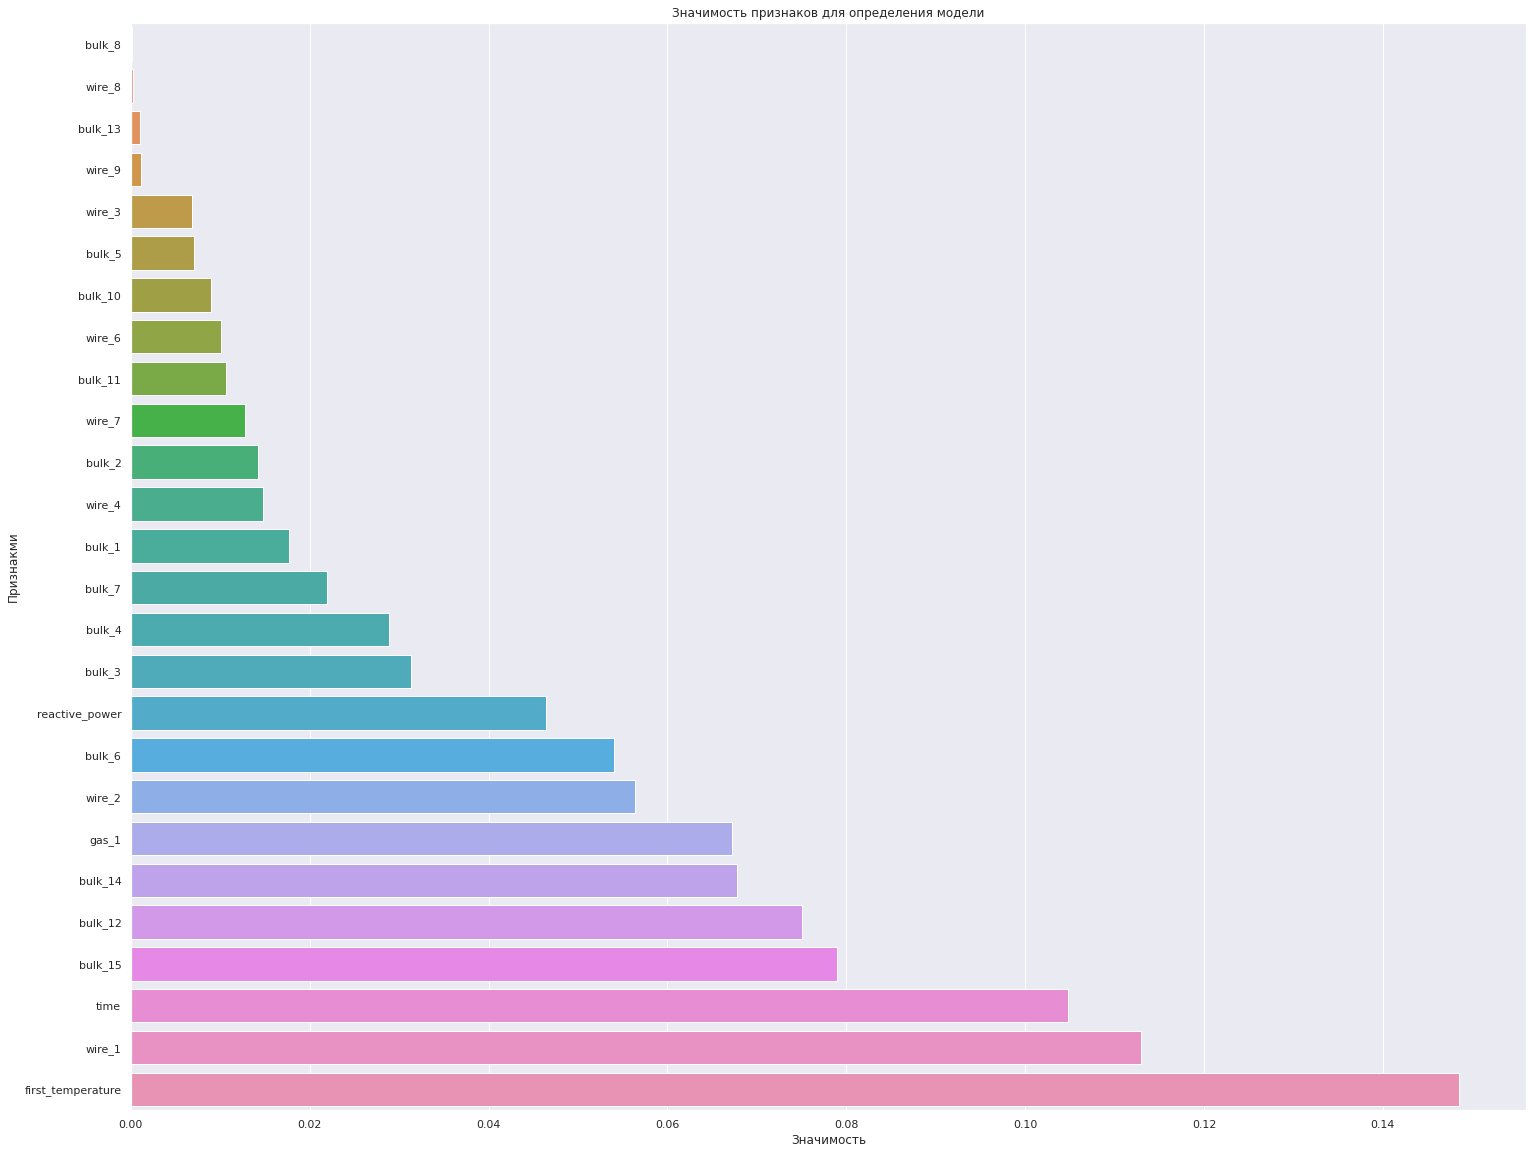

In [72]:
importances = pd.Series(model_RFR.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='green')
sns.set(rc={"figure.figsize":(25, 20)})
sns.barplot(x=importances, y=importances.index)
plt.xlabel("Значимость")
plt.ylabel("Признакми")
plt.title("Значимость признаков для определения модели")
plt.show()

Самымы важным призаком для предсказания итоговой температуры является начальная температура. На втором месте время выдержки и добавка с названием wire_1. 

Наименьшее влияение оказали сыпучие материалы bulk_8 и bulk_13, также проволочные материалы wire_8 и wire_9

В дальнейшем для экономии ресурсов и увеличения скорость обучения модели можно обучать модель исключив из выборки наименее важные признаки для обучения. Для примера обучим модель без этих признаков

In [73]:
# иключаем наименее важные признаки
X_train_less = X.drop(['last_temperature', 'bulk_8', 'bulk_13', 'wire_8','wire_9'], axis = 1)
X_test_less = y.drop(['last_temperature', 'bulk_8', 'bulk_13', 'wire_8','wire_9'], axis = 1)



In [74]:
%%time

model_RFR_less = RandomForestRegressor(n_estimators=150, max_depth=12, max_features='sqrt',  random_state=RST) # создание модели
model_RFR_less.fit(X_train_less, y_train) # обучение модели на тренировочной выборке
predictions = model_RFR_less.predict(X_test_less) # предсказания модели на тестовой выборке

# находим среднее отклонение
print("MAE: {:.2f}".format(mean_absolute_error(y_test, predictions)))
print()
print("RMSE: {:.2f}".format(mean_squared_error(y_test, predictions)))
print()
print("MAPE: {:.2f}".format(mape(y_test, predictions)))


MAE: 6.78

RMSE: 80.34

MAPE: 0.42
CPU times: user 559 ms, sys: 3.98 ms, total: 563 ms
Wall time: 561 ms


Удаление малозначимыз признаков действительно не повлияло на обучение модели

### Итоговый вывод

1. Подготовили данные, заменили пропуску и устранили аномалии. Проверили данные на гиперкорреляцию. Разбили данные на выборки, обучающую, валидационную и тестовую. Обучили модели, нашли лучшую. Провели проверку модели на тестовых данных.


2. Модель RandomForestRegressor показала себя наилучшим образом, можно рекомендовать эту модель к использованию.


3. Определили наиболее и наименее значимые признаки для предсказания конечной температуры расплава.